# Boundary conditions

To solve the differential equation problems involved in SeisCL modelisation, we obviously need to set boundary conditions. Dirichelet boundary condition can't be used effectively in numerical simulation since it causes artificials reflections. To minimise those reflections, we then want to use absorbings boundaries around our domain.

Two absorbing boundary type are implemented : the convolutional perfectly matched layer (CPML) [Komatitsch and Martin (2007)](https://doi.org/10.1190/1.2757586) and the dissipative layer of [Cerjan, et al., 1985](https://doi.org/10.1190/1.1441945).

## Theory

### 1. Cerjan

Cerjan et Al. have described a simple absorbing boundary layer in which the numerical grid is enlarged by a few grid points (typically 30 grid points) in each direction. The values of the stress and particle velocity in this boundary frame are multiplied by a factor "damp" : 

$$ \textrm{damp} = e^{-a^2 x^2} \tag{1} $$

with $ a = \sqrt{\dfrac{-\log(\textrm{amp})}{\textrm{FW}}} $ and $\textrm{amp} = 0.92$. The seismic waves are damped inside the boundary frame and cannot be reflected back into the model.

<br>

However, with Cerjan's simple formulation, the wavefield is still partialy reflected at the boundary between the absorbent layer and the model.

<br>

### 2. PML

The perfectly matched layer distinguishes itself from an ordinary absorbing material by being designed so that waves incident upon the PML from a non-PML medium do not reflect at the interface. This property allows the PML to strongly absorb outgoing waves from the interior of a computational region without reflecting them back into the interior.

First derived by [Berenger](https://doi.org/10.1006/jcph.1994.1159), the idea behind PML is to use a coordinate transformation into complex coordinates replacing propagating (oscillating) waves by exponentially decaying waves.


$$ \tilde{x}\,(x) = x - \frac{i}{\omega} \int_{0}^{x} d_x(s) \, ds  \qquad \rightarrow  \qquad \partial_{\tilde{x}} = \ \frac{\mathrm{i} \omega}{\mathrm{i} \omega+d_{x}} \partial_{x} \ = \ \frac{1}{s_x} \partial_x  \tag{2}$$


where $\omega$  is the angular frequency and $d_x(s)$ is a damping profile in x. Wherever $d_x(s)$ is positive, propagating waves are attenuated because it introduces a negative exponential factor :

<br>

$$ \normalsize e^{-i(\mathbf{k} \tilde{x} - \omega t)} \qquad \rightarrow \qquad  e^{-\mathbf{i}(\mathbf{k} \cdot \mathbf{x}-\omega t)} e^{-k_{x} / \omega \int_{0}^{x} d_{x}(s) \mathrm{d} s} \tag{3}$$

<br>

In SeisCL, Komiatitsch Convolutional Perfectly Matched Layer (CPML) formulation is used to improve the discrete model at grazing incidence. In this formulation, two variables $\alpha_x \geq 0 $ and $\kappa_x \geq 0$ are added to make $s_x$ more general: 


$$s_{x}=\kappa_{x}+\frac{d_{x}}{\alpha_{x}+\mathrm{i} \omega} \tag{4}$$


If we return in the time domain and some manipulations detailed in [Komatitsch article](https://doi.org/10.1190/1.2757586) we get :

$$ \partial_{\tilde{x}}=\frac{1}{\kappa_{x}} \partial_{x}+\psi_{x} \tag{5}$$

where $\psi_{x}$ is the memory variable.

<br>

Finally, the damping profile is chosen to follow [Collino and Tsogka](https://doi.org/10.1190/1.1444908) and is define by :

$$ d(x)=d_{0}\left(\frac{x}{\delta}\right)^{4} \qquad \qquad \textrm{with} \qquad \qquad d_{0}=\log \left(\frac{1}{R}\right) \frac{4 V_{p}}{2 \delta} \tag{6}$$

where $\delta$ is the length of the layer $R$ is the reflection coefficient and $V_p$ is the p-wave velocity.



## Example - PML

We will start modeling a domain with a perfectly matched layer. As usual we import the relevant modules and we define the basic constants.

To choose the boundary type, the constant <code>abs_type</code> must be changed. By default, we have <code>abs_type = 1</code> which correspond to a PML.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from SeisCL import SeisCL
seisPML = SeisCL()

In [8]:
seisPML.csts['ND'] = 2
seisPML.csts['N'] = np.array([250, 500])
seisPML.csts['dt'] = dt = 0.25e-03
seisPML.csts['dh'] = dh = 2
seisPML.csts['NT'] = NT = 1500
seisPML.csts['FDORDER'] = 4

seisPML.csts['abs_type'] = 1    #Not necessary, abs_type = 1 is the default

Next, we can change the constants related to the CPML. Let's take a closer look at all of them : 

 - <code>nab</code> control the thickness of the layer.
 
 
 - <code>FPML</code> is the dominant frequency of the wavefield.
 
 
 - <code>VPPML</code> is the Vp velocity near the CPML boundary as seen in $(6)$.
 
 
 - <code>K_MAX_CPML</code> changes the k factor in the equation $(5)$ and as defined below. 
 
 
 - <code>NPOWER</code> is the exponent used in the equation below. 


 $\qquad k_x$ is define as : $ \normalsize \qquad \kappa_{x}(x)=1+\left(\kappa_{\max }-1\right)\left(\dfrac{x}{\delta}\right)^{m}$ $\hspace{0.2cm}$ (see [Gedney page 8.2](http://optics.sgu.ru/~ulianov/Students/Books/Applied_Optics/Gedney%20Computational%20Electromagnetics.pdf)) 

For this example, <code>nab</code> will be set to 10, whih corresponds, with <code>dh = 2</code> to an absorbing layer of 20m. 

As <code>K_MAX_CPML</code> and <code>NPOWER</code> can influence simulation stability, we will keep them at they're default value. 

In [9]:
seisPML.csts['nab'] = nab = 15

seisPML.csts['K_MAX_CPML'] = 2      #Default
seisPML.csts['NPOWER'] = 2          #Default

The previous notebooks didn't change the value of the relaxation frequency of the source, which is set to 15 Hz by default.

To change it, the constant <code>f0</code> must be changed. Likewise if a PML is used, <code>FPML</code> must also be changed so that the layer can absorb the correct frequency. 

In [10]:
seisPML.csts['f0'] = 20
seisPML.csts['FPML'] = 20

For the model, let's take the same three-layer model that we created in the [Model Building](Model_Building.ipynb) notebook.

In [11]:
Nz = seisPML.csts['N'][0]
Nx = seisPML.csts['N'][1]

vp = [3500, 2000, 2500]
vs = 2000
rho = 2000
taup = 0
taus = 0

Thick_vp = [Nz//5, Nz//3]

vp_1 = np.zeros((Thick_vp[0], Nx)) + vp[0]
vp_2 = np.zeros((Thick_vp[1], Nx)) + vp[1]
vp_3 = np.zeros((Nz-np.sum(Thick_vp), Nx)) + vp[2]

vp_all = np.vstack((vp_1, vp_2, vp_3))

vs_all = np.zeros(seisPML.csts['N']) + vs
rho_all = np.zeros(seisPML.csts['N']) + rho
taup_all = np.zeros(seisPML.csts['N']) + taup
taus_all = np.zeros(seisPML.csts['N']) + taus


Model3Layers = {"vp": vp_all, "rho": rho_all, "vs": vs_all, "taup": taup_all, "taus": taus_all}

Since, we have changed the p-wave velocity, <code>VPPML</code> must also be changed from its default $\small 3500 \:\textrm{m/s}$ to the mean value of the velocity.

In [12]:
seisPML.csts['VPPML'] = ( 3500/5 + 2000/3 + 2000*7/5 )

### Boundaries interactions with sources and receivers

A capital consideration to have with absorbing boundary conditions is to make sure that the absorbings layers won't  interfer with the sources and the receiver. Indeed, if either of them is located at the same grid point as the absorbing layer, the received wave will be greatly attenuated.
<br>

It is therefore important to set the position of both of them on the outside of the layer. It's a good pratice to also add a small buffer to remove any interference from the absorbing layer. In this example, we will set the buffer to twice the size of the order of the finite difference.

In [13]:
nbuf = seisPML.csts['FDORDER'] * 2

sx = (nab + nbuf) * dh
sy = 0
sz = (nab + nbuf) * dh
offmin = 20 * dh
offmax = (Nx - nab - nbuf) * dh - offmin
gx = np.arange(sx + offmin, sx + offmax, 8*dh)
gy = gx * 0
gz = gx * 0 + (nab + nbuf) * dh
offset = gx-sx

seisPML.src_pos_all = np.stack([[sx], [sy], [sz], [0], [2]], axis=0)

gsid = gz * 0
gid = np.arange(0, len(gz))
seisPML.rec_pos_all = np.stack([gx, gy, gz, gsid, gid, gx * 0 + 2,
                            gx * 0, gx * 0], axis=0)

Now we can visualize the geometry, source, receivers and boundary layers to make sure that no interference will take place.

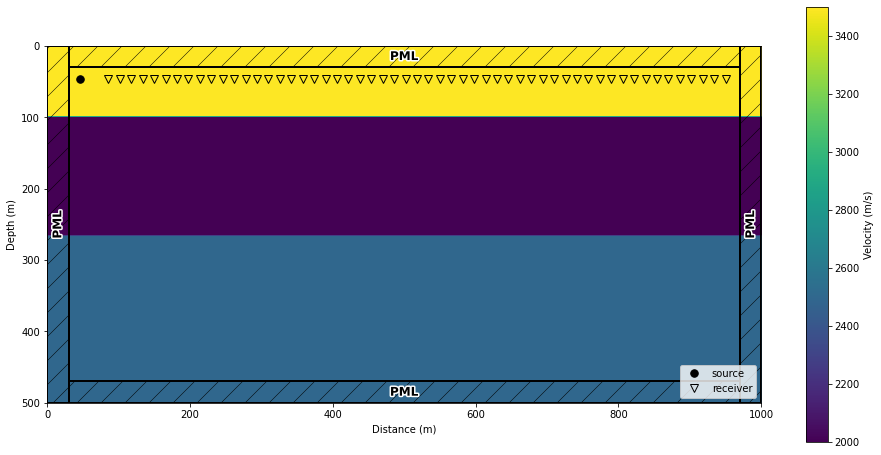

In [14]:
_, ax = plt.subplots(1, 1, figsize = (16,8))
seisPML.DrawDomain2D(vp_all, ax = ax, ShowAbs = True, ShowSrcRec = True)

## Comparison with Cerjan layer

Let's create a copy of our `SeisCL()` class and let's just change the parameter `abs_type = 2` to have a cerjan layer.

In [15]:
from copy import deepcopy

seisCerjan = deepcopy(seisPML)
seisCerjan.csts['abs_type'] = 2

Now we launch the simulation for both of them.

In [16]:
seisPML.set_forward(gsid, Model3Layers, withgrad=False)
InfoPML = seisPML.execute()
dataPML = seisPML.read_data()[-1]

seisCerjan.set_forward(gsid, Model3Layers, withgrad=False)
InfoCerjan = seisCerjan.execute()
dataCerjan = seisCerjan.read_data()[-1]

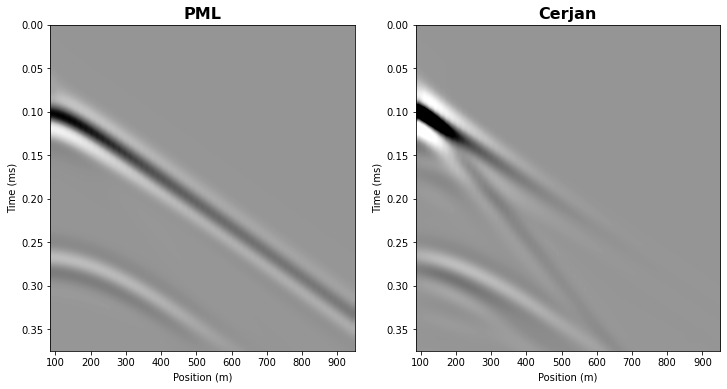

In [17]:
_, ax = plt.subplots(1, 2, figsize=[12, 6])
extent = [min(gx), max(gx), (dataPML.shape[0]-1)*dt, 0]
clip = 1
vmax = np.max(dataPML) * clip
vmin = -vmax
ax[0].imshow(dataPML, aspect='auto', vmax=vmax, vmin=vmin,
             extent=extent, interpolation='bilinear',
             cmap=plt.get_cmap('Greys'))
ax[0].set_title("PML", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Position (m)")
ax[0].set_ylabel("Time (ms)")

ax[1].imshow(dataCerjan, aspect='auto', vmax=vmax, vmin=vmin,
             extent=extent, interpolation='bilinear',
             cmap=plt.get_cmap('Greys'))
ax[1].set_title("Cerjan", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Position (m)")
ax[1].set_ylabel("Time (ms)")

plt.show()

As you can see, the Cerjan's layer create more reflections than PML which is why the latter is usually sugested.